In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from ultralytics import YOLO
import json
import xml.etree.ElementTree as ET
import tensorflow as tf
from tensorflow.keras import layers
import os
import cv2 as cv
from sklearn.model_selection import train_test_split
import random
import re
from PIL import Image

In [2]:
tf.keras.backend.clear_session()
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

In [3]:

# Step 1: Load the JSON file that contains the list of XML files
json_file = 'Dataset/splits.json'  # Path to your JSON file

with open(json_file, 'r') as f:
    data = json.load(f)

train_data = data["train"]  # Assuming this is a list of XML filenames for training
test_data = data["test"] # Assuming this is a list of XML filenames for training
val_data= data['val']

def process_xml_files(xml_file_list):
    bbox_results = {}
    
    for xml_file in xml_file_list:
        # Assume XML files are in the same directory or provide the path
        xml_path = xml_file  # adjust path if needed
        
        
        # Parse XML file
        xml_path=os.path.join("Dataset/annotated-images",xml_path)
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        # Extract bounding boxes (adjust XPath based on your XML structure)
        bbox_results[xml_file] = []
        
        # This XPath may vary depending on your XML structure
        for obj in root.findall('object'):
            # Find bounding box and class name elements
            class_name = obj.find('name').text
            
            bbox = obj.find('bndbox')
            if bbox is not None:
                xmin = int(bbox.find('xmin').text)
                ymin = int(bbox.find('ymin').text)
                xmax = int(bbox.find('xmax').text)
                ymax = int(bbox.find('ymax').text)
                
                # Store both formats
                bbox_info = {
                    "class": [class_name],
                    "bbox": [xmin, ymin, xmax, ymax]
                }

                bbox_results[xml_file].append(bbox_info)
    
    return bbox_results

train_data = process_xml_files(train_data)
test_data = process_xml_files(test_data)
val_data = process_xml_files(val_data)

In [4]:
train_data

{'img-110.xml': [{'class': ['pothole'], 'bbox': [224, 290, 638, 411]},
  {'class': ['pothole'], 'bbox': [82, 184, 180, 211]}],
 'img-578.xml': [{'class': ['pothole'], 'bbox': [102, 61, 378, 260]}],
 'img-455.xml': [{'class': ['pothole'], 'bbox': [266, 109, 323, 138]}],
 'img-87.xml': [{'class': ['pothole'], 'bbox': [235, 265, 440, 530]}],
 'img-213.xml': [{'class': ['pothole'], 'bbox': [244, 238, 472, 440]}],
 'img-369.xml': [{'class': ['pothole'], 'bbox': [1, 50, 471, 300]}],
 'img-37.xml': [{'class': ['pothole'], 'bbox': [180, 323, 396, 425]},
  {'class': ['pothole'], 'bbox': [305, 273, 525, 331]},
  {'class': ['pothole'], 'bbox': [537, 285, 626, 333]}],
 'img-59.xml': [{'class': ['pothole'], 'bbox': [218, 237, 522, 411]},
  {'class': ['pothole'], 'bbox': [249, 456, 426, 567]}],
 'img-83.xml': [{'class': ['pothole'], 'bbox': [276, 263, 468, 474]}],
 'img-431.xml': [{'class': ['pothole'], 'bbox': [92, 176, 177, 206]},
  {'class': ['pothole'], 'bbox': [119, 197, 435, 255]},
  {'class':

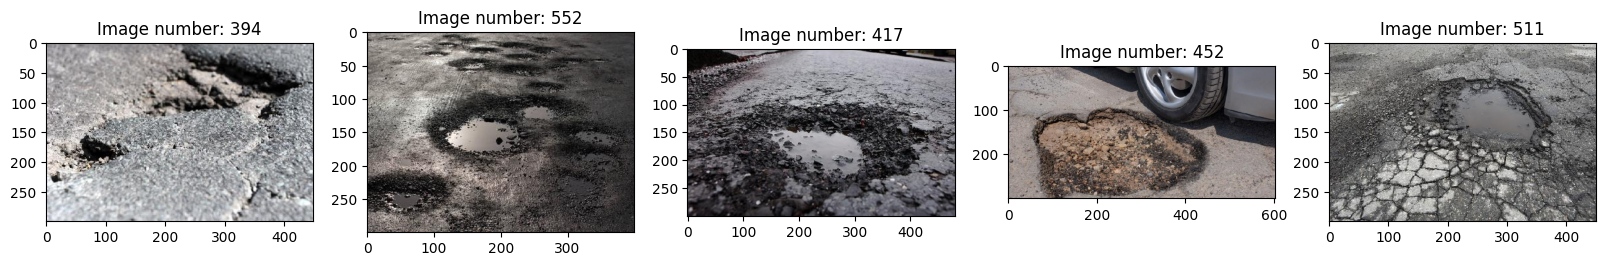

In [5]:
fig, ax=plt.subplots(ncols=5,figsize=(20,20))
for i in range(5):
    x=random.randrange(1,665)
    path=(f'Dataset/annotated-images/img-{x}.jpg')
    img=cv.imread(path)
    ax[i].imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
    ax[i].title.set_text(f'Image number: {x}')

In [6]:
# from PIL import Image
# import os

# # Path to the directory containing images
# image_folder = "Dataset/annotated-images"  # Adjust to your image directory
# image_dimensions = []

# # Loop through all images in the folder
# for image_name in os.listdir(image_folder):
#     image_path = os.path.join(image_folder, image_name)
#     if image_path.endswith(('.jpg')):  # Add more formats if needed
#         with Image.open(image_path) as img:
#             width, height = img.size  # Get dimensions
#             image_dimensions[image_name] = (width, height)

# # Print dimensions
# for image, (width, height) in image_dimensions.items():
#     print(f"{image}: Width={width}, Height={height}")


In [7]:
def get_dims(z):
    img_folder = "Dataset/annotated-images"
    image_dimensions = {}
    for i in z:
        image_path = f"Dataset/annotated-images/{i}"
        i=re.split('\.',i)[0]
        image_dimensions[i] = []
        if image_path.endswith(('.jpg')):  # Add more formats if needed
            with Image.open(image_path) as img:
                width, height = img.size  # Get dimensions
                img_dict={
                    "dims":[width, height]}
                image_dimensions[i].append(img_dict)
    return image_dimensions

In [8]:
re.split?

Signature: re.split(pattern, string, maxsplit=0, flags=0)
Docstring:
Split the source string by the occurrences of the pattern,
returning a list containing the resulting substrings.  If
capturing parentheses are used in pattern, then the text of all
groups in the pattern are also returned as part of the resulting
list.  If maxsplit is nonzero, at most maxsplit splits occur,
and the remainder of the string is returned as the final element
of the list.
File:      d:\anaconda\envs\tf_env3.8\lib\re.py
Type:      function

In [9]:
train_img_names=[key for key in train_data]
test_img_names=[key for key in test_data]
val_img_names =[key for key in val_data]

In [10]:
# Update each element in the list
train_img_names = [re.sub(r'\.xml', '.jpg', name) for name in train_img_names]
test_img_names = [re.sub('\.xml','.jpg', name) for name in test_img_names]
val_img_names = [re.sub('\.xml','.jpg',name) for name in val_img_names]

In [11]:
train_dims=get_dims(train_img_names)
test_dims=get_dims(test_img_names)
val_dims=get_dims(val_img_names)

In [12]:
train_dims

{'img-110': [{'dims': [720, 720]}],
 'img-578': [{'dims': [449, 300]}],
 'img-455': [{'dims': [455, 300]}],
 'img-87': [{'dims': [720, 720]}],
 'img-213': [{'dims': [720, 720]}],
 'img-369': [{'dims': [533, 300]}],
 'img-37': [{'dims': [720, 720]}],
 'img-59': [{'dims': [720, 720]}],
 'img-83': [{'dims': [720, 720]}],
 'img-431': [{'dims': [533, 300]}],
 'img-474': [{'dims': [401, 300]}],
 'img-370': [{'dims': [695, 300]}],
 'img-227': [{'dims': [720, 720]}],
 'img-661': [{'dims': [533, 300]}],
 'img-552': [{'dims': [400, 300]}],
 'img-433': [{'dims': [400, 300]}],
 'img-36': [{'dims': [720, 720]}],
 'img-316': [{'dims': [458, 300]}],
 'img-273': [{'dims': [720, 720]}],
 'img-659': [{'dims': [533, 300]}],
 'img-500': [{'dims': [300, 451]}],
 'img-561': [{'dims': [400, 300]}],
 'img-512': [{'dims': [400, 300]}],
 'img-251': [{'dims': [720, 720]}],
 'img-508': [{'dims': [533, 300]}],
 'img-522': [{'dims': [450, 300]}],
 'img-353': [{'dims': [400, 300]}],
 'img-392': [{'dims': [449, 300]}

In [13]:
def get_yolo(data,dims,t="train"):
    #annotation_folder = f"Dataset/annotations/{t}/labels" 
    if t == 'train':
        annotation_folder = "Dataset/annotations/train/labels"  # Output folder for YOLO annotation files
    elif t=='val':
        annotation_folder = "Dataset/annotations/val/labels"
    else:
        annotation_folder = "Dataset/annotations/test/labels"  
        
    os.makedirs(annotation_folder, exist_ok=True)
    for image_name, objects in data.items():
        img_name=re.split('\.',image_name)[0]
        width, height = dims[img_name][0].get('dims')
        annotation_file = os.path.join(annotation_folder, os.path.splitext(image_name)[0] + ".txt")
        with open(annotation_file, "w") as f:
            for obj in objects:
                class_id = 0
                xmin, ymin, xmax, ymax = obj["bbox"]
    
                # Convert to YOLO format (normalized values)
                x_center = (xmin + xmax) / 2 / width
                y_center = (ymin + ymax) / 2 / height
                bbox_width = (xmax - xmin) / width
                bbox_height = (ymax - ymin) / height
    
                # Write to file
                f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")

In [14]:
get_yolo(train_data,train_dims)
get_yolo(test_data,test_dims,"test")
get_yolo(val_data,val_dims,"val")

In [15]:
train_img=[]
for image_name, objects in train_data.items():
    train_img.append(image_name.split('.')[0])

In [16]:
test_img=[]
for image_name, objects in test_data.items():
    test_img.append(image_name.split('.')[0])

In [17]:
test_img_no=[]
for i in test_img:
    test_img_no.append(i.split('-')[1])

In [18]:
train_data.items()

dict_items([('img-110.xml', [{'class': ['pothole'], 'bbox': [224, 290, 638, 411]}, {'class': ['pothole'], 'bbox': [82, 184, 180, 211]}]), ('img-578.xml', [{'class': ['pothole'], 'bbox': [102, 61, 378, 260]}]), ('img-455.xml', [{'class': ['pothole'], 'bbox': [266, 109, 323, 138]}]), ('img-87.xml', [{'class': ['pothole'], 'bbox': [235, 265, 440, 530]}]), ('img-213.xml', [{'class': ['pothole'], 'bbox': [244, 238, 472, 440]}]), ('img-369.xml', [{'class': ['pothole'], 'bbox': [1, 50, 471, 300]}]), ('img-37.xml', [{'class': ['pothole'], 'bbox': [180, 323, 396, 425]}, {'class': ['pothole'], 'bbox': [305, 273, 525, 331]}, {'class': ['pothole'], 'bbox': [537, 285, 626, 333]}]), ('img-59.xml', [{'class': ['pothole'], 'bbox': [218, 237, 522, 411]}, {'class': ['pothole'], 'bbox': [249, 456, 426, 567]}]), ('img-83.xml', [{'class': ['pothole'], 'bbox': [276, 263, 468, 474]}]), ('img-431.xml', [{'class': ['pothole'], 'bbox': [92, 176, 177, 206]}, {'class': ['pothole'], 'bbox': [119, 197, 435, 255]}, 

In [19]:
import cv2
import os



image_folder = "Dataset/annotated-images"
# Desired dimensions or scaling factor
new_width = 512  # Replace with desired width
new_height = 512  # Replace with desired height

for filename in os.listdir(image_folder):
    if filename.split('.')[0] in train_img:
        print('g')
        output_directory = "Dataset/annotations/train/images"
    elif filename.split('.')[0] in test_img:
        output_directory = "Dataset/annotations/test/images"
    else:
        output_directory = "Dataset/annotations/val/images"
    os.makedirs(output_directory, exist_ok=True)
    if filename.endswith(('.jpg')):  # Check file extensions
        image_path = os.path.join(image_folder, filename)
        img = cv2.imread(image_path)
        if img is not None:  # Ensure the image is valid
            # Resize the image
            resized_image = cv2.resize(img, (new_width, new_height))
            # Save the resized image
            cv2.imwrite(os.path.join(output_directory, filename), resized_image)

print("All images have been resized and saved to the output directory.")


g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g


In [20]:
# def build_generator():
#     model = tf.keras.Sequential([
#         layers.Dense(16 * 16 * 256, activation='relu', input_dim=100),
#         layers.Reshape((16, 16, 256)),
#         layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', activation='relu'),  # 32 × 32
#         layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'),   # 64 × 64
#         layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', activation='relu'),   # 128 × 128
#         layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', activation='relu'),   # 256 × 256
#         layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid')  # Final output: 512 × 512 × 1
#     ])
#     return model


# # Define the discriminator
# def build_discriminator():
#     model = tf.keras.Sequential([
#         layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(512, 512, 1)),
#         layers.LeakyReLU(alpha=0.2),
#         layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
#         layers.LeakyReLU(alpha=0.2),
#         layers.Flatten(),
#         layers.Dense(1, activation='sigmoid')  # Output real/fake classification
#     ])
#     return model


# # Compile the models
# generator = build_generator()
# discriminator = build_discriminator()
# discriminator.compile(optimizer='adam', loss='binary_crossentropy')

# # GAN model
# discriminator.trainable = False
# gan_input = layers.Input(shape=(100,))
# x = generator(gan_input)
# gan_output = discriminator(x)
# gan = tf.keras.Model(gan_input, gan_output)
# gan.compile(optimizer='adam', loss='binary_crossentropy')

# save_folder = "generated_images"
# os.makedirs(save_folder, exist_ok=True)

# #Number of images to generate
# num_images = 10

# # Generate images
# for i in range(num_images):
#     # Generate random noise (replace with generator output)
#     noise = np.random.rand(512, 512, 3)  # For RGB images
#     noise = (noise * 255).astype(np.uint8)  # Scale pixel values to 0-255
    
#     # Convert array to image
#     img = Image.fromarray(noise)
    
#     # Save image
#     file_path = os.path.join(save_folder, f"generated_image_{i+1}.png")
#     img.save(file_path)
#     print(f"Image saved at {file_path}")

In [21]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


In [22]:
### GAN
# from tensorflow.keras import models
# from tensorflow.keras.optimizers import Adam


# # === Step 1: Image Generator Function ===
# def image_generator(folder, image_size=(512, 512), batch_size=32):
#     from itertools import cycle
#     images = []
#     for filename in cycle(os.listdir(folder)):
#         if filename.endswith(".jpg") or filename.endswith(".png"):
#             img_path = os.path.join(folder, filename)
#             img = Image.open(img_path).resize(image_size)
#             img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize to [0, 1]
#             if img_array.shape[-1] != 3:  # Ensure RGB format
#                 img_array = np.stack((img_array,) * 3, axis=-1)
#             images.append(img_array)
#             if len(images) == batch_size:
#                 yield np.array(images)
#                 images = []

# # Path to your input folder
# input_folder = r"C:\\Users\\user\\PotholeClassifierRT\\Dataset\\scaled-images"
# image_size = (512, 512)  # Image dimensions

# # === Step 2: Build the Generator ===
# def build_generator():
#     model = tf.keras.Sequential([
#         layers.Dense(16 * 16 * 256, activation='relu', input_dim=100),
#         layers.Reshape((16, 16, 256)),
#         layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', activation='relu'),  # 32x32
#         layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'),   # 64x64
#         layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', activation='relu'),   # 128x128
#         layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', activation='relu'),   # 256x256
#         layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='sigmoid')  # 512x512, RGB output
#     ])
#     return model

# generator = build_generator()

# # === Step 3: Build the Discriminator ===
# def build_discriminator():
#     model = tf.keras.Sequential([
#         layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=(512, 512, 3)),
#         layers.LeakyReLU(alpha=0.2),
#         layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
#         layers.LeakyReLU(alpha=0.2),
#         layers.Flatten(),
#         layers.Dense(1, activation='sigmoid')  # Output probability of real/fake
#     ])
#     return model

# discriminator = build_discriminator()
# discriminator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')

# # === Step 4: Compile the GAN ===
# discriminator.trainable = False
# gan_input = layers.Input(shape=(100,))
# x = generator(gan_input)
# gan_output = discriminator(x)
# gan = tf.keras.Model(gan_input, gan_output)
# gan.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')

# # === Step 5: Training the GAN ===
# def train_gan(generator, discriminator, gan, folder, epochs=100, batch_size=32):
#     image_gen = image_generator(folder, batch_size=batch_size)  # Initialize generator
#     steps_per_epoch = len(os.listdir(folder)) // batch_size

#     for epoch in range(epochs):
#         for step in range(steps_per_epoch):
#             # --- Train Discriminator ---
#             real_images = next(image_gen)
#             batch_size_actual = real_images.shape[0]
#             noise = np.random.normal(0, 1, (batch_size_actual, 100))
#             fake_images = generator.predict(noise)

#             real_labels = np.ones((batch_size_actual, 1))
#             fake_labels = np.zeros((batch_size_actual, 1))

#             d_loss_real = discriminator.train_on_batch(real_images, real_labels)
#             d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
#             d_loss = 0.5 * (d_loss_real + d_loss_fake)

#             # --- Train Generator ---
#             noise = np.random.normal(0, 1, (batch_size_actual, 100))
#             misleading_labels = np.ones((batch_size_actual, 1))  # Trick discriminator
#             g_loss = gan.train_on_batch(noise, misleading_labels)

#             print(f"Epoch {epoch+1}/{epochs}, Step {step+1}/{steps_per_epoch}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")

# # Train your GAN
# train_gan(generator, discriminator, gan, input_folder, epochs=5, batch_size=32)


1/1 [==============================] - 9s 9s/step
Epoch 1/5, Step 1/20, D Loss: 10.2764, G Loss: 0.0000
1/1 [==============================] - 0s 19ms/step
Epoch 1/5, Step 2/20, D Loss: 15.0859, G Loss: 0.0000
1/1 [==============================] - 0s 16ms/step
Epoch 1/5, Step 3/20, D Loss: 18.1094, G Loss: 0.0000
1/1 [==============================] - 0s 16ms/step
Epoch 1/5, Step 4/20, D Loss: 19.8750, G Loss: 0.0000
1/1 [==============================] - 0s 15ms/step
Epoch 1/5, Step 5/20, D Loss: 20.8750, G Loss: 0.0928
1/1 [==============================] - 0s 19ms/step
Epoch 1/5, Step 6/20, D Loss: 0.0490, G Loss: 12.3281
1/1 [==============================] - 0s 17ms/step
Epoch 1/5, Step 7/20, D Loss: 8.0547, G Loss: 1.8984
1/1 [==============================] - 0s 17ms/step
Epoch 1/5, Step 8/20, D Loss: 1.9722, G Loss: 1.4414
1/1 [==============================] - 0s 16ms/step
Epoch 1/5, Step 9/20, D Loss: 1.2427, G Loss: 1.3750
1/1 [==============================] - 0s 14ms/step

KeyboardInterrupt: 

In [23]:
### GAN
# save_folder = "generated_images"
# os.makedirs(save_folder, exist_ok=True)

# num_images = 10  # Number of images to generate
# for i in range(num_images):
#     # Generate noise and images
#     noise = np.random.normal(0, 1, (1, 100))  # Latent space input
#     generated_image = generator.predict(noise)
#     scaled_image = (generated_image[0] * 255).astype(np.uint8)  # Scale to 0-255
    
#     # Save generated image
#     img = Image.fromarray(scaled_image,'RGB')
#     file_path = os.path.join(save_folder, f"generated_image_{i + 1}.png")
#     img.save(file_path)
#     print(f"Image saved at {file_path}")

1/1 [==============================] - 1s 504ms/step
Image saved at generated_images\generated_image_1.png
1/1 [==============================] - 0s 17ms/step
Image saved at generated_images\generated_image_2.png
1/1 [==============================] - 0s 18ms/step
Image saved at generated_images\generated_image_3.png
1/1 [==============================] - 0s 17ms/step
Image saved at generated_images\generated_image_4.png
1/1 [==============================] - 0s 18ms/step
Image saved at generated_images\generated_image_5.png
1/1 [==============================] - 0s 18ms/step
Image saved at generated_images\generated_image_6.png
1/1 [==============================] - 0s 18ms/step
Image saved at generated_images\generated_image_7.png
1/1 [==============================] - 0s 32ms/step
Image saved at generated_images\generated_image_8.png
1/1 [==============================] - 0s 17ms/step
Image saved at generated_images\generated_image_9.png
1/1 [==============================] - 0s 16m

In [24]:
### GAN
#generator.summary()  # Inspect the output shape


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 65536)             6619136   
                                                                 
 reshape (Reshape)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 128)      819328    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 64)       204864    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 128, 128, 32)     51232     
 ranspose)                                                       
                                                        

In [3]:
# Load a COCO-pretrained YOLOv8n model
model = YOLO("yolov8n.pt")

# Display model information (optional)
model.info()

results = model.train(data='Dataset/split.yaml', epochs=10, imgsz=512,batch=32)

# # Run inference with the YOLOv8n model on the 'bus.jpg' image
# results = model("path/to/bus.jpg")

YOLOv8n summary: 129 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs
New https://pypi.org/project/ultralytics/8.3.128 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.91  Python-3.8.20 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=Dataset/split.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train20, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False

train: Scanning C:\Users\user\PotholeClassifierRT\Dataset\annotations\train\labels.cache... 532 images, 0 backgrounds, 0 corrupt: 100%|██████████| 532/532 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


C:\Users\user\AppData\Roaming\Python\Python38\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.6 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning C:\Users\user\PotholeClassifierRT\Dataset\annotations\val\labels.cache... 78 images, 0 backgrounds, 0 corrupt: 100%|██████████| 78/78 [00:00<?, ?it/s]


Plotting labels to runs\detect\train20\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/05/07 21:58:11 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/07 21:58:11 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2025/05/07 21:58:11 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.


MLflow: logging run_id(d85b4896ffcf46128391f9fa17e17650) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added 
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to runs\detect\train20
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.62G      1.735      3.105      1.595         54        512: 100%|██████████| 17/17 [00:06<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

                   all         78        175     0.0065      0.869      0.265      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.01G      1.444      1.974      1.334         60        512: 100%|██████████| 17/17 [00:04<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         78        175        0.9     0.0512      0.327       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.01G      1.434      1.827       1.35         48        512: 100%|██████████| 17/17 [00:04<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]

                   all         78        175      0.524      0.251      0.314       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.02G      1.404      1.708       1.34         55        512: 100%|██████████| 17/17 [00:04<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]

                   all         78        175      0.268      0.257      0.213      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.02G      1.427      1.612      1.334         50        512: 100%|██████████| 17/17 [00:04<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

                   all         78        175      0.432      0.377      0.344      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.02G      1.378      1.492      1.303         53        512: 100%|██████████| 17/17 [00:04<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]

                   all         78        175      0.398      0.309      0.308      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.02G      1.324      1.418       1.26         54        512: 100%|██████████| 17/17 [00:04<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         78        175       0.39      0.391      0.322      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.02G      1.282      1.283      1.234         46        512: 100%|██████████| 17/17 [00:04<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

                   all         78        175      0.512      0.514      0.516      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.02G      1.232      1.243      1.206         48        512: 100%|██████████| 17/17 [00:04<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         78        175      0.592      0.679      0.695       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.02G      1.188      1.162      1.178         76        512: 100%|██████████| 17/17 [00:04<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         78        175      0.682      0.651      0.723      0.436



10 epochs completed in 0.028 hours.
Optimizer stripped from runs\detect\train20\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train20\weights\best.pt, 6.2MB

Validating runs\detect\train20\weights\best.pt...
Ultralytics 8.3.91  Python-3.8.20 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]


                   all         78        175      0.681      0.651      0.723      0.438
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\train20
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'


In [4]:
os.makedirs('Models', exist_ok=True)
model.save('Models/model2.pt')

In [6]:
# mlflow ui --backend-store-uri "file:///C:/Users/user/TrafficLightClassifierRT/mlruns"
import mlflow

# Use local MLflow tracking (default path is ./mlruns)
mlflow.set_tracking_uri("file:///C:/Users/user/PotholeClassifierRT/runs/mlflow")
mlflow.set_experiment("Autonomous Vehicle")


2025/05/07 22:24:56 INFO mlflow.tracking.fluent: Experiment with name 'Autonomous Vehicle' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/user/PotholeClassifierRT/runs/mlflow/770639824555890519', creation_time=1746645897002, experiment_id='770639824555890519', last_update_time=1746645897002, lifecycle_stage='active', name='Autonomous Vehicle', tags={}>

In [32]:
 results = model(r"C:\Users\user\PotholeClassifierRT\Dataset\annotations\test\images\img-133.jpg")


image 1/1 C:\Users\user\PotholeClassifierRT\Dataset\annotations\test\images\img-133.jpg: 512x512 1 pothole, 34.8ms
Speed: 3.9ms preprocess, 34.8ms inference, 9.8ms postprocess per image at shape (1, 3, 512, 512)


In [33]:
results = model.predict(
    source=r'C:\Users\user\PotholeClassifierRT\Dataset\annotations\test\images',
    conf=0.25,
    save=True,
    project='results',      # Custom project name
    name='test_annotations' # Custom folder name
)


image 1/55 C:\Users\user\PotholeClassifierRT\Dataset\annotations\test\images\img-120.jpg: 512x512 1 pothole, 34.6ms
image 2/55 C:\Users\user\PotholeClassifierRT\Dataset\annotations\test\images\img-121.jpg: 512x512 2 potholes, 34.7ms
image 3/55 C:\Users\user\PotholeClassifierRT\Dataset\annotations\test\images\img-133.jpg: 512x512 1 pothole, 34.4ms
image 4/55 C:\Users\user\PotholeClassifierRT\Dataset\annotations\test\images\img-137.jpg: 512x512 1 pothole, 35.4ms
image 5/55 C:\Users\user\PotholeClassifierRT\Dataset\annotations\test\images\img-169.jpg: 512x512 2 potholes, 27.5ms
image 6/55 C:\Users\user\PotholeClassifierRT\Dataset\annotations\test\images\img-190.jpg: 512x512 2 potholes, 18.8ms
image 7/55 C:\Users\user\PotholeClassifierRT\Dataset\annotations\test\images\img-193.jpg: 512x512 2 potholes, 17.9ms
image 8/55 C:\Users\user\PotholeClassifierRT\Dataset\annotations\test\images\img-205.jpg: 512x512 2 potholes, 17.6ms
image 9/55 C:\Users\user\PotholeClassifierRT\Dataset\annotations\t

In [34]:
test_img_no[54]

'282'

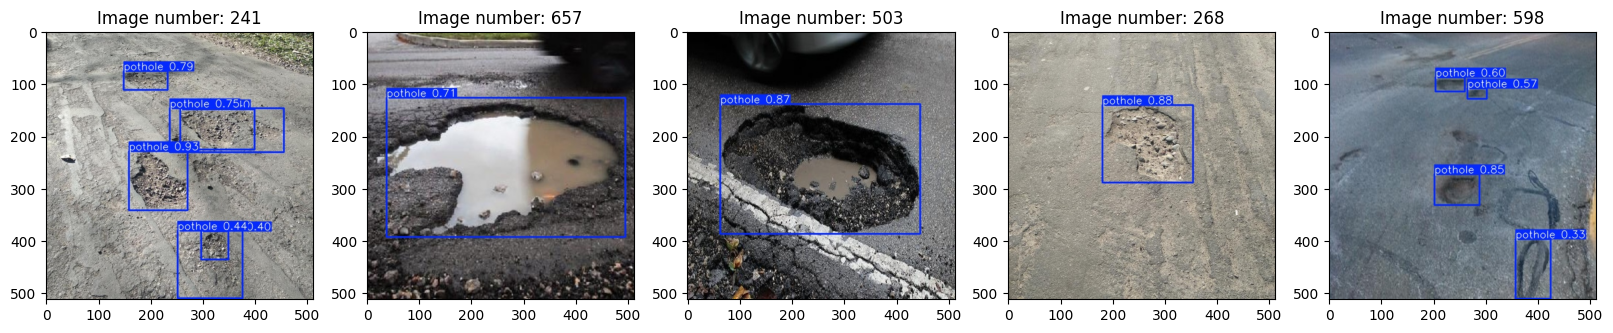

In [35]:
fig, ax=plt.subplots(ncols=5,figsize=(20,20))
for i in range(5):
    x=random.randrange(0,54)
    x=test_img_no[x]
    path=(f'results/test_annotations/img-{x}.jpg')
    img=cv.imread(path)
    ax[i].imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
    ax[i].title.set_text(f'Image number: {x}')

In [36]:
model=YOLO('Models/model.pt')

In [41]:
def videocap(x=0):
    cap = cv.VideoCapture(x)

    # Define codec and create VideoWriter object
    os.makedirs('results/videos', exist_ok=True)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # You can change codec (e.g., 'XVID', 'MJPG', etc.)
    out = cv2.VideoWriter('results/videos/output.avi', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
    
        # Perform object detection
        results = model(frame)
    
        # Visualize results
        annotated_frame = results[0].plot()
        out.write(annotated_frame)
        cv.imshow('YOLOv8 Real-Time Detection', annotated_frame)
    
        # Exit on pressing the escape key.
        if cv.waitKey(1) & 0xFF == 27:
            break

    out.release()
    cap.release()
    cv2.destroyAllWindows()


In [ ]:
videocap()

In [43]:
videocap(r"C:\Users\user\Downloads\mixkit-potholes-in-a-rural-road-25208-hd-ready.mp4")


0: 288x512 (no detections), 28.2ms
Speed: 6.0ms preprocess, 28.2ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 512)

0: 288x512 1 pothole, 22.3ms
Speed: 3.1ms preprocess, 22.3ms inference, 4.3ms postprocess per image at shape (1, 3, 288, 512)

0: 288x512 1 pothole, 22.5ms
Speed: 5.2ms preprocess, 22.5ms inference, 1.9ms postprocess per image at shape (1, 3, 288, 512)

0: 288x512 2 potholes, 21.9ms
Speed: 4.1ms preprocess, 21.9ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 512)

0: 288x512 2 potholes, 22.8ms
Speed: 3.9ms preprocess, 22.8ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 512)

0: 288x512 2 potholes, 22.0ms
Speed: 3.9ms preprocess, 22.0ms inference, 2.6ms postprocess per image at shape (1, 3, 288, 512)

0: 288x512 2 potholes, 23.3ms
Speed: 3.4ms preprocess, 23.3ms inference, 1.9ms postprocess per image at shape (1, 3, 288, 512)

0: 288x512 1 pothole, 21.2ms
Speed: 3.2ms preprocess, 21.2ms inference, 2.7ms postprocess per image 